In [11]:
from django.core.management import setup_environ
import settings
setup_environ(settings)

'/home/wahern/projects/millstone/genome_designer'

In [40]:
import os

import pysam

from main.models import Contig
from main.models import Dataset
from genome_finish import insertion_placement_read_trkg
from genome_finish.assembly import add_bam_track

# contig2_label = 'mg1655_lib1_rec07_NODE_22_length_5491_cov_157.923141'
contig2_label = 'ins_1kb_ins_1kb_sample_NODE_1_length_1966_cov_23.010174'
contig = Contig.objects.get(label=contig2_label)

unmapped_contig_reads = insertion_placement_read_trkg.extract_contig_reads(contig, read_category='unmapped')
print len(unmapped_contig_reads), 'unmapped reads in contig'

original_align = contig.experiment_sample_to_alignment.dataset_set.get(type=Dataset.TYPE.BWA_ALIGN).get_absolute_location()
original_alignmentfile = pysam.AlignmentFile(original_align)
found_mates = []
for read in unmapped_contig_reads:
    if not read.mate_is_unmapped:
        mate = original_alignmentfile.mate(read)
        found_mates.append(mate)
print len(found_mates), 'mapped mates found'

mates_of_unmapped_bam_file = os.path.join(
        contig.get_model_data_dir(), 'mates_of_unmapped.bam')
mates_of_unmapped_alignment_file = pysam.AlignmentFile(
    mates_of_unmapped_bam_file, "wb", template=original_alignmentfile)
for read in found_mates:
    mates_of_unmapped_alignment_file.write(read)
mates_of_unmapped_alignment_file.close()

label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
        str(contig.num_bases) + '_mates_of_unmapped')
add_bam_track(contig.parent_reference_genome, mates_of_unmapped_bam_file, label)



390 unmapped reads in contig
150 mapped mates found
add_bam_file_track entered
created related models
sorted bam
indexed bam
about to add bam file track
added bam file track


In [41]:
label

'Contig_1_length_1986_mates_of_unmapped'

In [16]:
from main.models import ExperimentSampleToAlignment
from main.models import Dataset
alignment_dir = ExperimentSampleToAlignment.objects.get(alignment_group__label = 'lib1_rec07_align_a').get_model_data_dir()

In [32]:
reload(assembly)

<module 'genome_finish.assembly' from 'genome_finish/assembly.py'>

In [18]:
import os
import genome_finish.assembly as assembly

In [33]:
from main.models import ReferenceGenome
mg1655 = ReferenceGenome.objects.get(label='mg1655')
sv_indicants_no_mates_bam = os.path.join(alignment_dir, 'genome_finishing/0/bwa_align.SV_indicants_no_dups.bam')

In [36]:
print sv_indicants_no_mates_bam
assert os.path.exists(sv_indicants_no_mates_bam)

/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/alignment_groups/b66efb92/sample_alignments/0418e714/genome_finishing/0/bwa_align.SV_indicants_no_dups.bam


In [37]:
mg1655.num_bases

4641652L

In [38]:
assembly.add_bam_track(mg1655, sv_indicants_no_mates_bam, 'split_unmapped_no_mates_3')

add_bam_file_track entered
created related models
sorted bam
indexed bam
about to add bam file track
added bam file track


In [31]:
from main.models import ExperimentSample
es = ExperimentSample.objects.get(label='lib1_rec07')
es.dataset_set.all()[1].wrap_if_compressed()

'<(gzip -dc /home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/samples/eab3affa/tmpWISJgX_recoli_lib1_rec07_2.fq.gz)'

In [ ]:
# Filter low quality reads
from main.models import ExperimentSampleToAlignment
from main.models import Dataset
import pysam
sample_alignment = ExperimentSampleToAlignment.objects.get(alignment_group__label = 'lib1_rec07_align_a')
sample_alignment_bam = sample_alignment.dataset_set.get(type=Dataset.TYPE.BWA_ALIGN)

sample_alignmentfile = pysam.AlignmentFile(sample_alignment_bam)
counter = 0
iter
for read in sample_alignmentfile:

In [50]:
# Combine sv_indicant bam files

import genome_finish.millstone_de_novo_fns as millstone_de_novo_fns
from main.model_utils import get_dataset_with_type
from utils.bam_utils import concatenate_bams
from utils.bam_utils import make_bam
from utils.bam_utils import make_sam
from utils.bam_utils import rmdup
from utils.bam_utils import sort_bam_by_name

sample_alignment = ExperimentSampleToAlignment.objects.get(alignment_group__label = 'lib1_rec07_align_a')
data_dir = os.path.join(sample_alignment.get_model_data_dir(), 'genome_finishing/1')

sv_indicant_types = {
        'clipped': True,
        'split': True,
        'unmapped': True,
        'discordant': True
    }

alignment_prefix = os.path.join(data_dir, 'bwa_align')

# Extract SV indicating reads
sv_bams_list = []

unmapped_reads = alignment_prefix + '.unmapped.bam'
if sv_indicant_types['unmapped']:
    sv_bams_list.append(unmapped_reads)

split_reads = alignment_prefix + '.split.bam'
if sv_indicant_types['split']:
    sv_bams_list.append(split_reads)

clipped_reads = alignment_prefix + '.clipped.bam'
if sv_indicant_types['clipped']:
    sv_bams_list.append(clipped_reads)

if sv_indicant_types['discordant']:
    discordant_reads = sample_alignment.dataset_set.get(
            type=Dataset.TYPE.BWA_DISCORDANT).get_absolute_location()
    sv_bams_list.append(discordant_reads)


compilation_prefix = alignment_prefix + '.' + '_'.join([k for k in sorted(sv_indicant_types.keys()) if sv_indicant_types[k]])
# Aggregate SV indicants
SV_indicants_bam = compilation_prefix + '.bam'
# if os.path.exists(SV_indicants_bam):
#     raise Exception(SV_indicants_bam + ' already exists')

if not os.path.exists(SV_indicants_bam):
    concatenate_bams(
            sv_bams_list,
            SV_indicants_bam)

# Remove duplicates
print 'removing duplicates'
SV_indicants_no_dups_bam = compilation_prefix + '.no_dups.bam'
if not os.path.exists(SV_indicants_no_dups_bam):
    rmdup(SV_indicants_bam, SV_indicants_no_dups_bam)

# Convert SV indicants bam to sam
SV_indicants_sam = compilation_prefix + '.no_dups.sam'
if not os.path.exists(SV_indicants_sam):
    make_sam(SV_indicants_no_dups_bam, SV_indicants_sam)

# Add mate pairs to SV indicants sam
    # Grab alignment bam file-path
print 'adding mate pairs'
alignment_bam = get_dataset_with_type(
        sample_alignment,
        Dataset.TYPE.BWA_ALIGN).get_absolute_location()
SV_indicants_with_pairs_sam = (
    compilation_prefix + '.with_pairs.sam')
if not os.path.exists(SV_indicants_with_pairs_sam):
    millstone_de_novo_fns.add_paired_mates(
            SV_indicants_sam, alignment_bam, SV_indicants_with_pairs_sam)

# Make bam of SV indicants w/mate pairs
SV_indicants_with_pairs_bam = (
    compilation_prefix + '.with_pairs.bam')
if not os.path.exists(SV_indicants_with_pairs_bam):
    make_bam(SV_indicants_with_pairs_sam, SV_indicants_with_pairs_bam)

# Sort for velvet assembly
print 'sorting'
sort_bam_by_name(SV_indicants_with_pairs_bam)

print SV_indicants_with_pairs_bam

removing duplicates
adding mate pairs
sorting
/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/alignment_groups/b66efb92/sample_alignments/0418e714/genome_finishing/1/bwa_align.clipped_discordant_split_unmapped.with_pairs.bam


In [62]:
#Assemble

from genome_finish import assembly
from pipeline.read_alignment import get_insert_size_mean_and_stdev

sample_alignment = ExperimentSampleToAlignment.objects.get(alignment_group__label = 'lib1_rec07_align_a')
data_dir = os.path.join(sample_alignment.get_model_data_dir(), 'genome_finishing/1')

sv_indicants_bam = ('/home/wahern/projects/millstone/genome_designer/conf/../' +
        'temp_data/projects/6e766eb8/alignment_groups/b66efb92/sample_alignments/' +
        '0418e714/genome_finishing/1/bwa_align.clipped_discordant_split_unmapped.with_pairs.bam')

# Find insertion metrics
ins_length, ins_length_sd = get_insert_size_mean_and_stdev(
        sample_alignment)
velvet_opts = {
    'velveth': {
        'shortPaired': ''
    },
    'velvetg': {
        'read_trkg': 'yes',
        'ins_length': ins_length,
        'ins_length_sd': ins_length_sd,
        'cov_cutoff': 30,
    }
}

reference_genome = sample_alignment.alignment_group.reference_genome

contig_label_base = '_'.join(
            [reference_genome.label, sample_alignment.experiment_sample.label])


run_id = 'run_0_'


assembly.assemble_with_velvet(data_dir, velvet_opts, sv_indicants_bam,
        reference_genome, sample_alignment,
        contig_label_base, velvet_dir_prefix = run_id)

['/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/alignment_groups/b66efb92/sample_alignments/0418e714/genome_finishing/1/run_0_velvet_k21/contigs.fa']

In [60]:
reload(assembly)

<module 'genome_finish.assembly' from 'genome_finish/assembly.pyc'>

In [63]:
import os

import pysam

from main.models import Contig
from main.models import Dataset
from genome_finish import insertion_placement_read_trkg
from genome_finish.assembly import add_bam_track

# contig_label = 'mg1655_lib1_rec07_NODE_22_length_5491_cov_157.923141'
# contig_label = 'ins_1kb_ins_1kb_sample_NODE_1_length_1966_cov_23.010174'
contig_label = 'mg1655_lib1_rec07_NODE_114_length_1007_cov_137.319763'
contig = Contig.objects.get(label=contig_label)

unmapped_contig_reads = insertion_placement_read_trkg.extract_contig_reads(contig, read_category='unmapped')
print len(unmapped_contig_reads), 'unmapped reads in contig'

original_align = contig.experiment_sample_to_alignment.dataset_set.get(type=Dataset.TYPE.BWA_ALIGN).get_absolute_location()
original_alignmentfile = pysam.AlignmentFile(original_align)
found_mates = []
for read in unmapped_contig_reads:
    if not read.mate_is_unmapped:
        mate = original_alignmentfile.mate(read)
        found_mates.append(mate)
print len(found_mates), 'mapped mates found'

mates_of_unmapped_bam_file = os.path.join(
        contig.get_model_data_dir(), 'mates_of_unmapped.bam')
mates_of_unmapped_alignment_file = pysam.AlignmentFile(
    mates_of_unmapped_bam_file, "wb", template=original_alignmentfile)
for read in found_mates:
    mates_of_unmapped_alignment_file.write(read)
mates_of_unmapped_alignment_file.close()

# label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
#         str(contig.num_bases) + '_mates_of_unmapped')
# add_bam_track(contig.parent_reference_genome, mates_of_unmapped_bam_file, label)



1797 unmapped reads in contig
37 mapped mates found


In [68]:
label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
        str(contig.num_bases) + '_mates_of_unmapped')
add_bam_track(contig.parent_reference_genome, mates_of_unmapped_bam_file, label)

add_bam_file_track entered
created related models
sorted bam
indexed bam
about to add bam file track
added bam file track


In [66]:
%matplotlib inline

(array([  3.,   2.,   2.,   3.,   1.,   1.,  21.,   1.,   1.,   2.]),
 array([  190852. ,   625884.8,  1060917.6,  1495950.4,  1930983.2,
         2366016. ,  2801048.8,  3236081.6,  3671114.4,  4106147.2,
         4541180. ]),
 <a list of 10 Patch objects>)

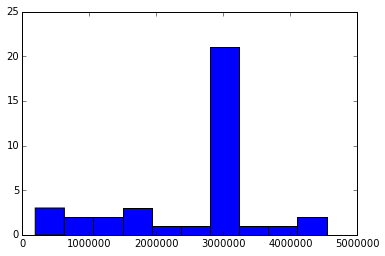

In [67]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist([read.reference_end for read in found_mates])

In [59]:
ls /home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/alignment_groups/b66efb92/sample_alignments/0418e714/genome_finishing

0/  1/  assembly_0/


In [69]:
d1 = {1:11,2:22}
d2 = {}
d1.update(d2)

In [70]:
d1

{1: 11, 2: 22}

In [72]:
import pickle
import os

data_dir = '/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/ecbcef23/alignment_groups/85ad25c6/sample_alignments/37886b79/assembly/3'
metadata_file = os.path.join(data_dir, 'metadata.txt')

In [73]:
os.path.exists(metadata_file)

True

In [75]:
with open(metadata_file) as fh:
    metadata_obj = pickle.load(fh)

In [77]:
metadata_obj['sv_indicants_bam']

'/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/ecbcef23/alignment_groups/85ad25c6/sample_alignments/37886b79/bwa_align.discordant_split_clipped_unmapped.with_pairs.bam'

In [78]:
metadata_obj['velvet_opts']

{'velvetg': {'cov_cutoff': 10,
  'ins_length': 499,
  'ins_length_sd': 2,
  'read_trkg': 'yes'},
 'velveth': {'hash_length': 21, 'shortPaired': ''}}